
# Quantum machine learning using variational quantum circuits.

## Libraries

The set of libraries required to run the notebook

In [1]:

from quantum_classical_circuits import dataManagement as dm
from quantum_classical_circuits import quantum_circuits as qc
import pennylane as qml
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss


2022-09-13 20:46:13.377854: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-13 20:46:13.377891: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-13 20:46:13.408844: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-13 20:46:14.162685: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-09-13 20:46:14.162766: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca


## Handling the credit card dataset

### Loading the dataset

The first step is to load the dataset and split the content into feature space and class, so that it is easier to handle the information afterwards.

In [2]:

# The dataset folder is included outside the workspace in a folder named datasets.
datafile_fraud = "../datasets/creditcard.csv"
start_index = 1
end_index = 29
class_index = 30
xVals, yVals = dm.read_data(datafile_fraud, start_index=start_index, end_index=end_index, class_index=class_index, k_lines=4)

# Fraud cases
iFraud = yVals[yVals == 1]
indexesFraud = list(iFraud.keys())

# Clean cases
iClean = yVals[yVals == 0]
indexesClean = list(iClean.keys())

print("Fraud cases: ", len(indexesFraud))
print("Clean cases: ", len(indexesClean))

# Shift label from {0, 1} to {-1, 1}
yVals = yVals * 2 - np.ones(len(yVals))  # shift label from {0, 1} to {-1, 1}


            Time        V1        V2        V3        V4        V5        V6  \
0            0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1            0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
...          ...       ...       ...       ...       ...       ...       ...   
284805  172788.0 -0.240440  0.530483  0.702510  0.689799 -0.377961  0.623708   
284806  172792.0 -0.533413 -0.189733  0.703337 -0.506271 -0.012546 -0.649617   

              V7        V8        V9       V10       V11       V12       V13  \
0       0.239599  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390   
1      -0.078803  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095   
...          ...       ...       ...       ...       ...       ...       ...   
284805 -0.686180  0.679145  0.392087 -0.399126 -1.933849 -0.962886 -1.042082   
284806  1.577006 -0.414650  0.486180 -0.915427 -1.040458 -0.031513 -0.188093   

             V14       V15       V16  


### Preparing the train and test set

In order to balance the dataset a oversampling technique (SMOTE) is utilized in combination with an undersampling one (Near Miss). The sampling technique achieves a middle point where the newly sampled of the minority class cases and the undersampled cases of the majority class are equal without forcing one another.

In [3]:

X_train, X_test, y_train, y_test = train_test_split(xVals, yVals, test_size = 0.25, random_state = 0)
print("Before OverSampling, counts of label FRAUD('1') in the training set: {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label CLEAN('0') in the training: {} \n".format(sum(y_train == -1)))

sm = SMOTE(sampling_strategy = 0.01, random_state = 6)
X_train_os, y_train_os = sm.fit_resample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_os.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_os.shape))
  
print("After OverSampling, counts of label FRAUD('1'): {}".format(sum(y_train_os == 1)))
print("After OverSampling, counts of label CLEAN('0'): {}".format(sum(y_train_os == -1)))

nr = NearMiss(sampling_strategy = 1.0)
X_train_balanced, y_train_balanced = nr.fit_resample(X_train_os, y_train_os.ravel())

print('After Undersampling, the shape of train_X: {}'.format(X_train_balanced.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_balanced.shape))
  
print("After Undersampling, counts of label FRAUD('1'): {}".format(sum(y_train_balanced == 1)))
print("After Undersampling, counts of label CLEAN('0'): {}".format(sum(y_train_balanced == -1)))


Before OverSampling, counts of label FRAUD('1') in the training set: 372
Before OverSampling, counts of label CLEAN('0') in the training: 213233 

After OverSampling, the shape of train_X: (215365, 28)
After OverSampling, the shape of train_y: (215365,) 

After OverSampling, counts of label FRAUD('1'): 2132
After OverSampling, counts of label CLEAN('0'): 213233
After Undersampling, the shape of train_X: (4264, 28)
After Undersampling, the shape of train_y: (4264,) 

After Undersampling, counts of label FRAUD('1'): 2132
After Undersampling, counts of label CLEAN('0'): 2132


# Model 1: Quantum variational classifier with amplitude embedding

## Training the quantum circuit

In [31]:

iterations = 5 # Number of iterations through the training set
l_rate = 0.01 # Learning rate of the optimizer
n_layers = 2
n_qubits = 5
n_operation = 3 # The rotation takes 3 variables
# c_type = 'AE'
x_dataset = tf.constant(X_train_balanced)
y_dataset = tf.constant(y_train_balanced)

class CustomModel(tf.keras.Model):
    def train_step(self, data):
        
        x_data, y_data = data

        with tf.GradientTape() as tape:
            y_pred = self(x_data, training=True)  # Forward pass
            # Compute the loss value.
            # The loss function is configured in `compile()`.
            loss = self.compiled_loss(
                y_data,
                y_pred,
                regularization_losses=self.losses
                )

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics.
        # Metrics are configured in `compile()`.
        self.compiled_metrics.update_state(y_data, y_pred)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}


In [32]:

dir_weights = "./model_weights/qcircuit_AE" # Pretrained model weights
weight_shapes = {"qcircuit_parameters": [n_layers, n_qubits, n_operation]}
load_weights = True
history = None
inputs = tf.keras.Input(shape=(28,), name='Input')
qlayer = qml.qnn.KerasLayer(qc.qcircuit_amplitude_embedding_kl, weight_shapes=weight_shapes, output_dim=n_qubits, name='Quantum', weight_specs = {"weights": {"initializer": "random_uniform", "seed": 6}})(inputs)
outputs = tf.keras.layers.Dense(units=1, activation="linear", name='LinearDense', kernel_initializer=tf.initializers.RandomNormal(seed=6))(qlayer)
model = CustomModel(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_rate), loss="mse", metrics=["mae"])

if not load_weights:
    history = model.fit(x_dataset, y_dataset, epochs=iterations, batch_size=100)
else:
    model.fit(x_dataset[:1], y_dataset[:1], epochs=iterations, batch_size=100)


Epoch 1/5
1/1 [==============================] - 0s 295ms/step - loss: 1.0749 - mae: 1.0368
Epoch 2/5
1/1 [==============================] - 0s 260ms/step - loss: 1.0181 - mae: 1.0090
Epoch 3/5
1/1 [==============================] - 0s 275ms/step - loss: 0.9639 - mae: 0.9818
Epoch 4/5
1/1 [==============================] - 0s 284ms/step - loss: 0.9122 - mae: 0.9551
Epoch 5/5
1/1 [==============================] - 0s 276ms/step - loss: 0.8623 - mae: 0.9286


### Saving model weights for future use

In [33]:

if load_weights:
    model.load_weights(filepath=dir_weights)
else:
    model.save_weights(filepath=dir_weights)


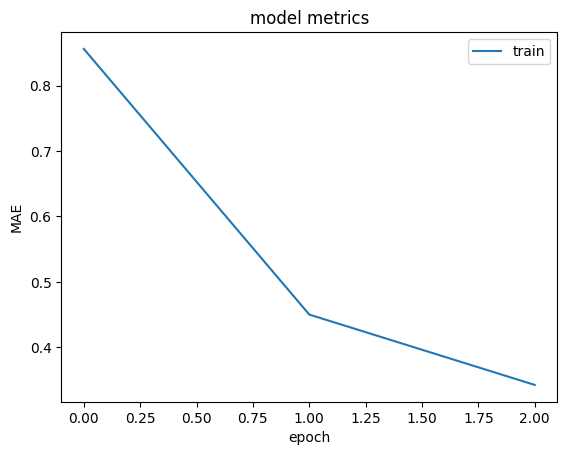

In [15]:

if not load_weights:
    plt.plot(history.history['mae'])
    plt.title('model metrics')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper right')
    plot_dir = "./plots/qc_ae_mae.png"
    plt.savefig(fname=plot_dir)


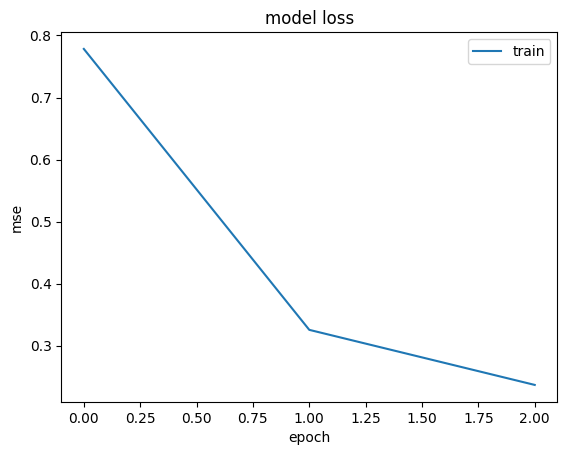

In [16]:

if not load_weights:
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper right')
    plot_dir = "./plots/qc_ae_loss.png"
    plt.savefig(fname=plot_dir)


## Testing the quantum circuit

In [31]:

x_dataset_test = tf.constant(X_test)
y_dataset_test = tf.constant(y_test)
x_test_fraud = x_dataset_test[y_dataset_test == 1]
y_test_fraud = y_dataset_test[y_dataset_test == 1]
x_test_clean = x_dataset_test[y_dataset_test == -1][:x_test_fraud.shape[0]]
y_test_clean = y_dataset_test[y_dataset_test == -1][:x_test_fraud.shape[0]]


In [33]:

test_size = 1000
x_dataset_test = tf.constant(X_test)[:test_size]
y_dataset_test = tf.constant(y_test)[:test_size]
result = model.evaluate(x=x_dataset_test, y=y_dataset_test)
dict(zip(model.metrics_names, result))


32/32 [==============================] - 97s 3s/step - loss: 0.9188 - mae: 0.8395


{'loss': 0.9188438057899475, 'mae': 0.839545488357544}

In [23]:

predictions_fraud = model.predict(x=x_test_fraud)
predictions_clean = model.predict(x=x_test_clean)


4/4 [==============================] - 11s 3s/step


## Plots

Plots help visualize the specific distance between the desired value (eigenvalue +1 or -1) and the predicted value.

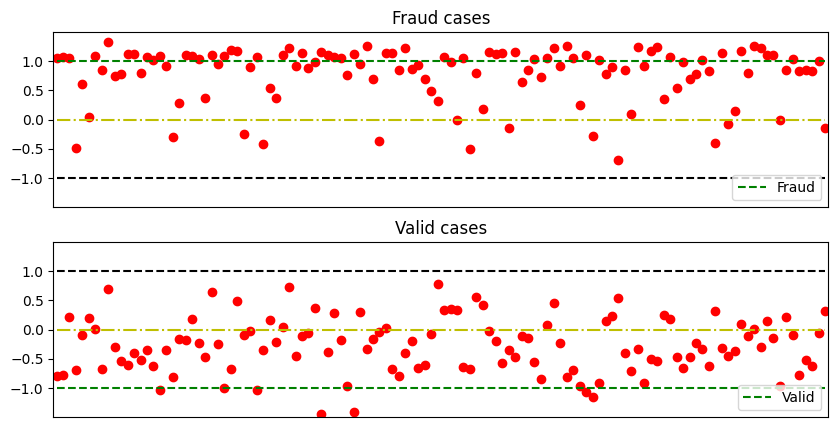

In [91]:

from turtle import color


pfraud_points = predictions_fraud.shape[0]
pclean_points = predictions_clean.shape[0]

bottom_val = -1.5
top_val = 1.5
x_left = -0.5
x_right = pfraud_points + 0.5

x_fraud = np.linspace(0, pfraud_points, pfraud_points)
x_clean = np.linspace(0, pclean_points, pclean_points)

positive_line = np.full(shape=pfraud_points, fill_value=1)
middle_line = np.full(shape=pfraud_points, fill_value=0)
negative_line = np.full(shape=pclean_points, fill_value=-1)

fig, axs = plt.subplots(2, 1, figsize=(10,5))

axs[0].scatter(x_fraud, predictions_fraud, c='r')
axs[0].plot(x_fraud, positive_line, color='g', linestyle="dashed", label="Fraud")
axs[0].plot(x_fraud, middle_line, color='y', linestyle="-.")
axs[0].plot(x_fraud, negative_line, color='k', linestyle="dashed")
axs[0].set_title('Fraud cases')
axs[0].set_yticks([-1, -0.5, 0, 0.5, 1])
axs[0].set_xlim(x_left, x_right)
axs[0].set_ylim(bottom_val, top_val)
axs[0].set_xticks([])
axs[0].legend(loc='lower right')

axs[1].scatter(x_clean, predictions_clean, c='r')
axs[1].plot(x_clean, positive_line, color='k', linestyle="dashed")
axs[1].plot(x_clean, middle_line, color='y', linestyle="-.")
axs[1].plot(x_clean, negative_line, color='g', linestyle="dashed", label="Valid")
axs[1].set_title('Valid cases')
axs[1].set_yticks([-1, -0.5, 0, 0.5, 1])
axs[1].set_xlim(x_left, x_right)
axs[1].set_ylim(bottom_val, top_val)
axs[1].set_xticks([])
axs[1].legend(loc='lower right')

plot_dir = "./plots/ae_fv_scatter.png"
plt.savefig(fname=plot_dir)


## Visualizing the model

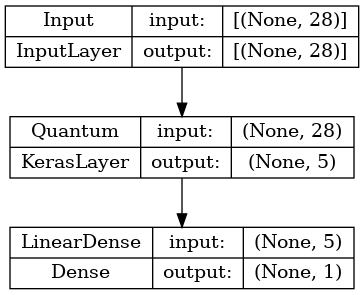

In [52]:

dir_qcircuit_image = "./model_diagrams/qcircuit_ae.png"
tf.keras.utils.plot_model(model=model, to_file=dir_qcircuit_image, show_shapes=True)


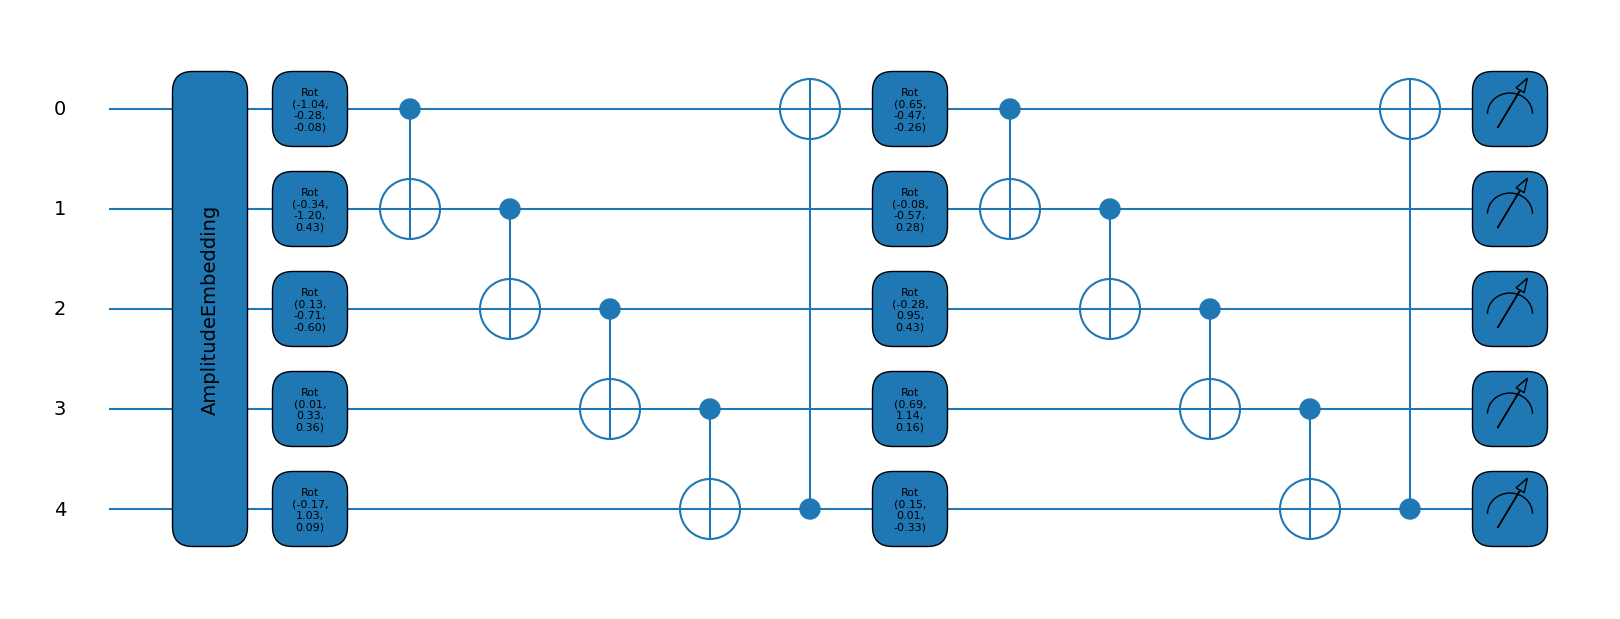

In [34]:

circuit_dir = "./model_diagrams/qcircuit_ae_qgates.png"
fig, ax = qml.draw_mpl(qc.qcircuit_amplitude_embedding_kl, decimals = 2)(x_dataset[0], model.layers[1].weights[0])
plt.savefig(fname=circuit_dir)


# Model 2: Quantum variational classifier with data reuploading

## Training the quantum circuit

In [4]:
iterations = 5 # Number of iterations through the training set
l_rate = 0.01 # Learning rate of the optimizer
n_layers = 2
n_qubits = 5
n_operation = 3 # The rotation takes 3 variables
# c_type = 'AE'
x_dataset = tf.constant(X_train_balanced)
y_dataset = tf.constant(y_train_balanced)

class CustomModel(tf.keras.Model):
    def train_step(self, data):
        
        x_data, y_data = data

        with tf.GradientTape() as tape:
            y_pred = self(x_data, training=True)  # Forward pass
            # Compute the loss value.
            # The loss function is configured in `compile()`.
            loss = self.compiled_loss(
                y_data,
                y_pred,
                regularization_losses=self.losses
                )

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics.
        # Metrics are configured in `compile()`.
        self.compiled_metrics.update_state(y_data, y_pred)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}

In [35]:

dir_weights = "./model_weights/qcircuit_DR" # Pretrained model weights
load_weights = True
weight_shapes = {"qcircuit_parameters": [n_layers, n_qubits, n_operation]}
inputs_2 = tf.keras.Input(shape=(28,), name='Input')
qlayer_2 = qml.qnn.KerasLayer(qc.qcircuit_data_reuploading_kl, weight_shapes=weight_shapes, output_dim=n_qubits, name='Quantum', weight_specs = {"weights": {"initializer": "random_uniform", "seed": 6}})(inputs_2)
outputs_2 = tf.keras.layers.Dense(units=1, activation="linear", name='LinearDense', kernel_initializer=tf.initializers.RandomNormal(seed=6))(qlayer_2)
model_2 = CustomModel(inputs_2, outputs_2)
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=l_rate), loss="mse", metrics=["mae"])

if not load_weights:
    history_2 = model_2.fit(x_dataset, y_dataset, epochs=5, batch_size=100)
else:
    model_2.fit(x_dataset[:1], y_dataset[:1], epochs=5, batch_size=100)


Epoch 1/5
1/1 [==============================] - 1s 967ms/step - loss: 0.9182 - mae: 0.9582
Epoch 2/5
1/1 [==============================] - 1s 944ms/step - loss: 0.8582 - mae: 0.9264
Epoch 3/5
1/1 [==============================] - 1s 915ms/step - loss: 0.7975 - mae: 0.8930
Epoch 4/5
1/1 [==============================] - 1s 927ms/step - loss: 0.7362 - mae: 0.8580
Epoch 5/5
1/1 [==============================] - 1s 898ms/step - loss: 0.6745 - mae: 0.8213


### Saving model weights for future use

In [36]:

if load_weights:
    model_2.load_weights(filepath=dir_weights)
else:
    model_2.save_weights(filepath=dir_weights)
    

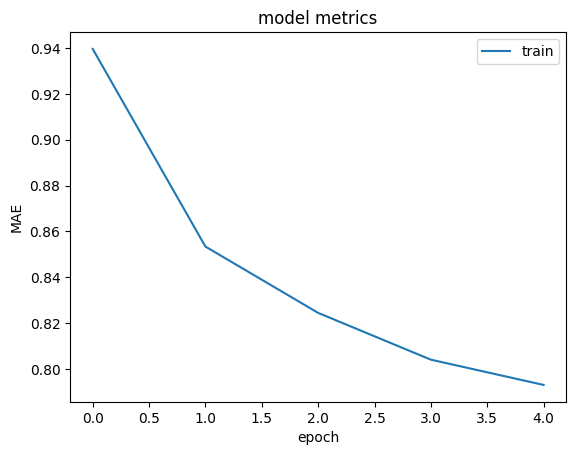

In [7]:

if not load_weights:
    plt.plot(history_2.history['mae'])
    plt.title('model metrics')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper right')
    plot_dir = "./plots/qc_dr_mae.png"
    plt.savefig(fname=plot_dir)
    

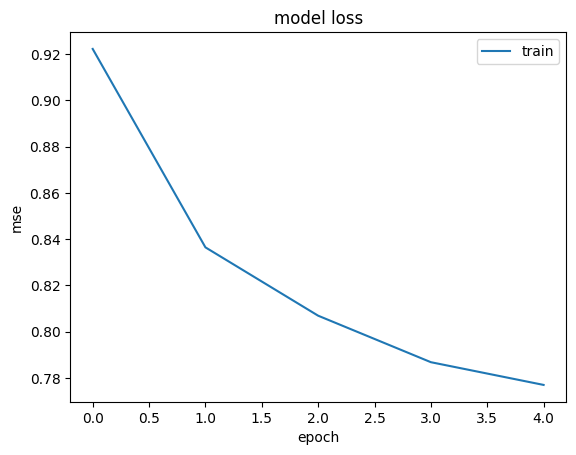

In [8]:

if not load_weights:
    plt.plot(history_2.history['loss'])
    plt.title('model loss')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper right')
    plot_dir = "./plots/qc_dr_loss.png"
    plt.savefig(fname=plot_dir)


## Testing the quantum circuit

In [9]:

x_dataset_test = tf.constant(X_test)
y_dataset_test = tf.constant(y_test)
x_test_fraud = x_dataset_test[y_dataset_test == 1]
y_test_fraud = y_dataset_test[y_dataset_test == 1]
x_test_clean = x_dataset_test[y_dataset_test == -1][:x_test_fraud.shape[0]]
y_test_clean = y_dataset_test[y_dataset_test == -1][:x_test_fraud.shape[0]]


In [10]:

test_size = 1000
x_dataset_test = tf.constant(X_test)[:test_size]
y_dataset_test = tf.constant(y_test)[:test_size]
result = model_2.evaluate(x=x_dataset_test, y=y_dataset_test)
dict(zip(model_2.metrics_names, result))


32/32 [==============================] - 743s 23s/step - loss: 1.4183 - mae: 1.1264


{'loss': 1.4182864427566528, 'mae': 1.126420497894287}

In [11]:

predictions_fraud = model_2.predict(x=x_test_fraud)
predictions_clean = model_2.predict(x=x_test_clean)


4/4 [==============================] - 84s 21s/step


## Plots
Plots help visualize the specific distance between the desired value (eigenvalue +1 or -1) and the predicted value.

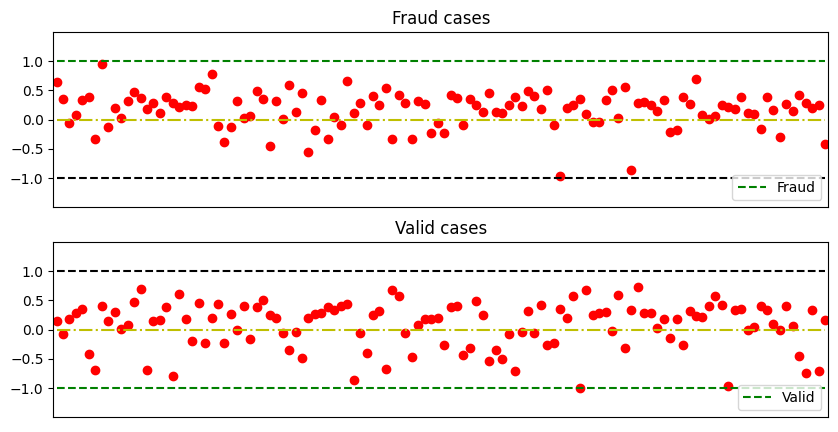

In [12]:
from turtle import color


pfraud_points = predictions_fraud.shape[0]
pclean_points = predictions_clean.shape[0]

bottom_val = -1.5
top_val = 1.5
x_left = -0.5
x_right = pfraud_points + 0.5

x_fraud = np.linspace(0, pfraud_points, pfraud_points)
x_clean = np.linspace(0, pclean_points, pclean_points)

positive_line = np.full(shape=pfraud_points, fill_value=1)
middle_line = np.full(shape=pfraud_points, fill_value=0)
negative_line = np.full(shape=pclean_points, fill_value=-1)

fig, axs = plt.subplots(2, 1, figsize=(10,5))

axs[0].scatter(x_fraud, predictions_fraud, c='r')
axs[0].plot(x_fraud, positive_line, color='g', linestyle="dashed", label="Fraud")
axs[0].plot(x_fraud, middle_line, color='y', linestyle="-.")
axs[0].plot(x_fraud, negative_line, color='k', linestyle="dashed")
axs[0].set_title('Fraud cases')
axs[0].set_yticks([-1, -0.5, 0, 0.5, 1])
axs[0].set_xlim(x_left, x_right)
axs[0].set_ylim(bottom_val, top_val)
axs[0].set_xticks([])
axs[0].legend(loc='lower right')

axs[1].scatter(x_clean, predictions_clean, c='r')
axs[1].plot(x_clean, positive_line, color='k', linestyle="dashed")
axs[1].plot(x_clean, middle_line, color='y', linestyle="-.")
axs[1].plot(x_clean, negative_line, color='g', linestyle="dashed", label="Valid")
axs[1].set_title('Valid cases')
axs[1].set_yticks([-1, -0.5, 0, 0.5, 1])
axs[1].set_xlim(x_left, x_right)
axs[1].set_ylim(bottom_val, top_val)
axs[1].set_xticks([])
axs[1].legend(loc='lower right')

plot_dir = "./plots/dr_fv_scatter.png"
plt.savefig(fname=plot_dir)

## Visualizing the model

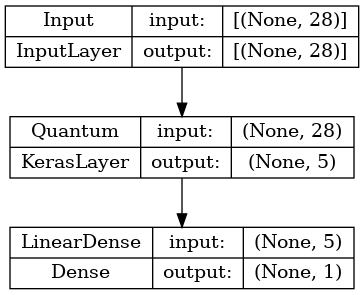

In [14]:

dir_qcircuit_image = "./model_diagrams/qcircuit_dr.png"
tf.keras.utils.plot_model(model=model_2, to_file=dir_qcircuit_image, show_shapes=True)

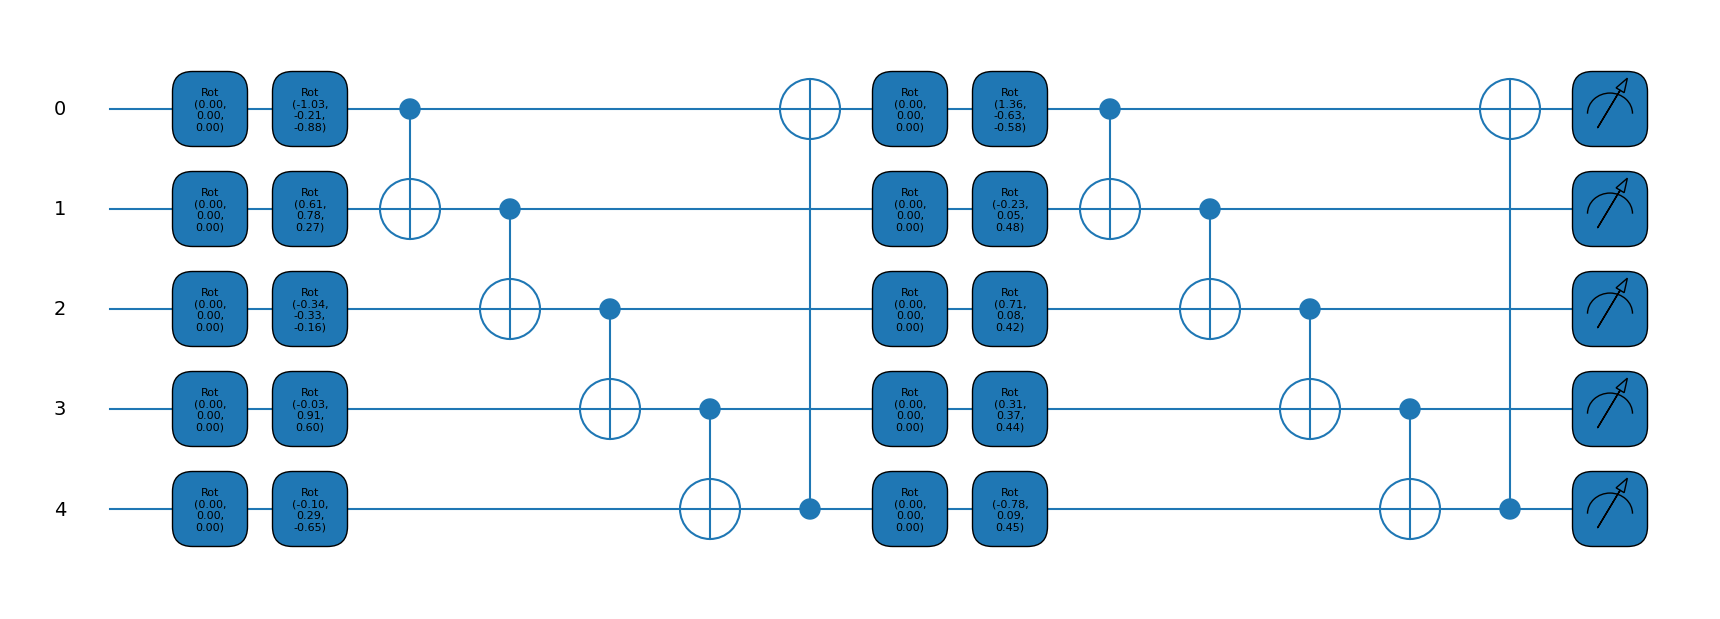

In [37]:
circuit_dir = "./model_diagrams/qcircuit_dr_qgates.png"
fig, ax = qml.draw_mpl(qc.qcircuit_data_reuploading_kl, decimals = 2)(tf.zeros(3), model_2.layers[1].weights[0])
plt.savefig(fname=circuit_dir)